In [4]:
import os
import pandas as pd
import numpy as np
import bisect
import pickle
import seaborn as sns
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
with open("preprocessed_data/train_df.pkl", 'rb') as f:
    train_df = pickle.load(f)
    X_train = train_df.drop(columns=["label"])
    y_train = train_df[["label"]]

with open("preprocessed_data/test_df.pkl", 'rb') as f:
    test_df = pickle.load(f)
    X_test = test_df.drop(columns=["label"])
    y_test = test_df[["label"]]

In [6]:
label_map = {0: 'tops', 1: 'bottoms', 2: 'bags', 3: 'shoes', 4: 'others'}
train_df['label_name'] = train_df['label'].map(label_map)

In [7]:
initial_dims = pd.read_csv("initial_dims.csv")
# initial_dims['pixel'] = initial_dims['width'] * initial_dims['height']
initial_dims

,filepath,category,width,height
0,dataset/train/tops/top_0260_augmented_0.jpeg,tops,430,574
1,dataset/train/tops/top_0063_augmented_0.jpeg,tops,480,640
2,dataset/train/tops/top_0465_augmented_0.jpeg,tops,513,684
3,dataset/train/tops/top_0116_augmented_2.jpeg,tops,480,640
4,dataset/train/tops/top_0128_augmented_2.jpeg,tops,480,640
...,...,...,...,...
12706,dataset/test/others/other_0001.jpeg,others,480,640
12707,dataset/test/others/other_0017.jpeg,others,360,640
12708,dataset/test/others/other_0021.jpeg,others,481,640
12709,dataset/test/others/other_0020.jpeg,others,480,640


In [8]:
# initial_dims_augmented = initial_dims[initial_dims['filepath'].str.contains("augmented")]
initial_dims_non_augmented = initial_dims[~initial_dims['filepath'].str.contains("augmented")]

In [9]:
X_train.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4086,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095
count,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,...,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000
mean,0.560468,0.563058,0.564218,0.565609,0.568051,0.570590,0.572565,0.574432,0.575947,0.576998,...,0.534863,0.534891,0.536039,0.536283,0.536680,0.536843,0.536040,0.534961,0.532950,0.531386
std,0.230498,0.228744,0.228250,0.227729,0.226701,0.226368,0.225613,0.224813,0.224641,0.224668,...,0.223441,0.223561,0.223337,0.223403,0.223198,0.223431,0.223614,0.223803,0.223774,0.224175
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.388235,0.396078,0.400000,0.400000,0.403922,0.407843,0.413725,0.415686,0.415686,0.419608,...,0.366667,0.364706,0.368627,0.364706,0.368627,0.368627,0.368627,0.368627,0.364706,0.360784
50%,0.588235,0.588235,0.592157,0.592157,0.592157,0.596078,0.600000,0.600000,0.600000,0.603922,...,0.549020,0.549020,0.552941,0.552941,0.552941,0.552941,0.549020,0.549020,0.545098,0.545098
75%,0.737255,0.741176,0.741176,0.741176,0.745098,0.745098,0.745098,0.749020,0.749020,0.749020,...,0.705882,0.705882,0.705882,0.705882,0.705882,0.705882,0.705882,0.705882,0.701961,0.698039
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
y_train.value_counts()

label
2        2845
1        2700
4        2150
3        1792
0         260
dtype: int64

# Image dimensions (before resizing)

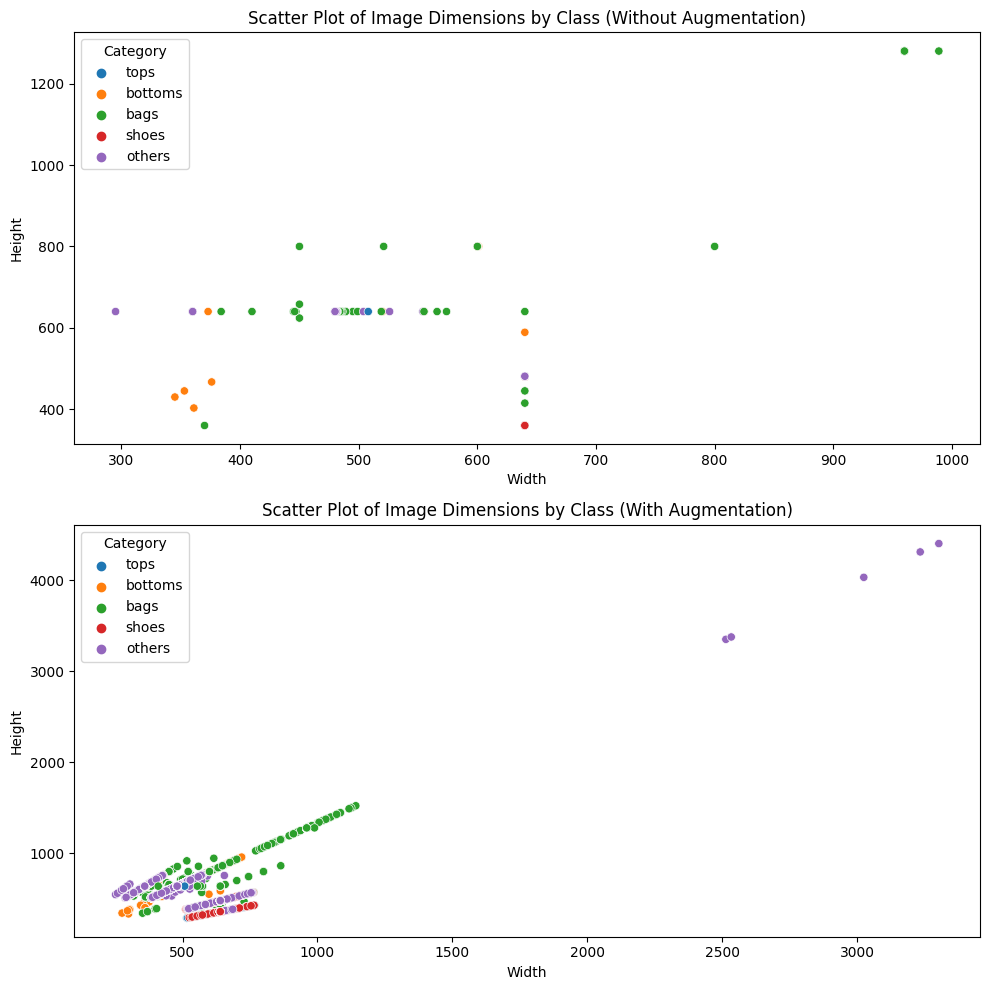

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plot the first scatter plot (without augmentation) on the first subplot
sns.scatterplot(data=initial_dims_non_augmented, x='width', y='height', hue='category', palette='tab10', ax=axes[0])
axes[0].set_title('Scatter Plot of Image Dimensions by Class (Without Augmentation)')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Height')
axes[0].legend(title='Category', loc='upper left')

# Plot the second scatter plot (with augmentation) on the second subplot
sns.scatterplot(data=initial_dims, x='width', y='height', hue='category', palette='tab10', ax=axes[1])
axes[1].set_title('Scatter Plot of Image Dimensions by Class (With Augmentation)')
axes[1].set_xlabel('Width')
axes[1].set_ylabel('Height')
axes[1].legend(title='Category', loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


<Figure size 1200x1000 with 0 Axes>

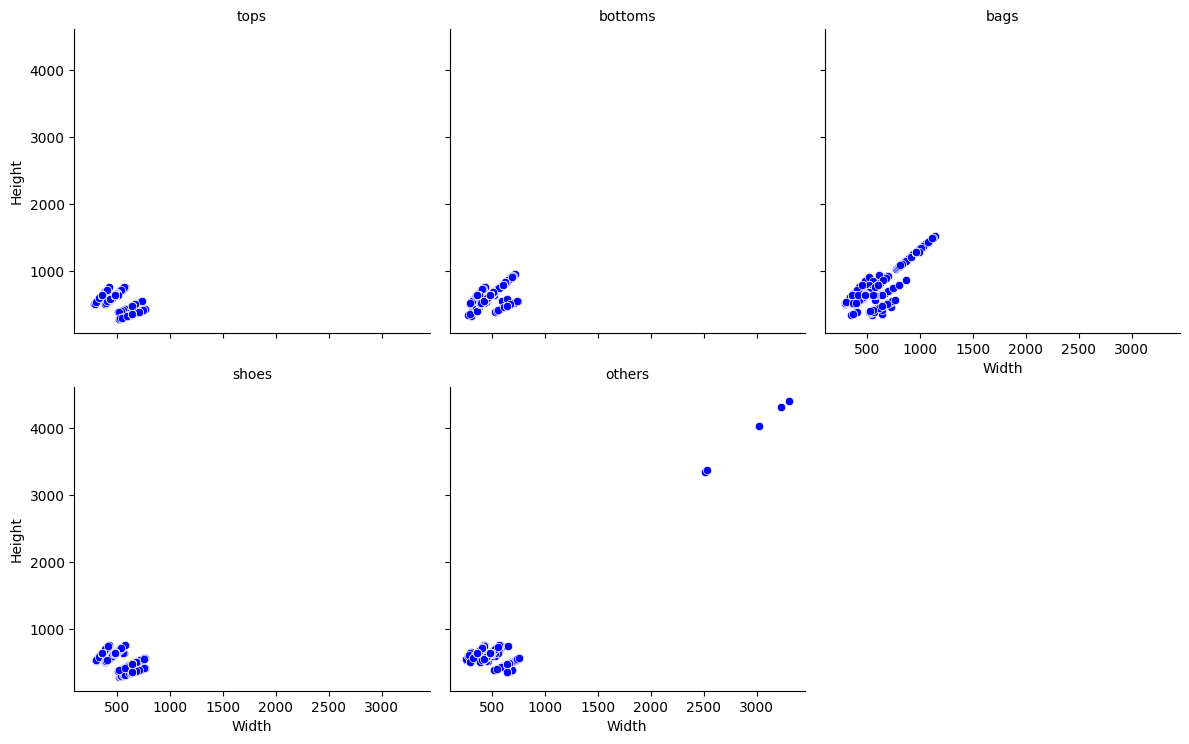

In [68]:
plt.figure(figsize=(12, 10))

# Create a FacetGrid with one scatter plot for each class
g = sns.FacetGrid(initial_dims, col='category', col_wrap=3, height=4)
g.map(sns.scatterplot, 'width', 'height', color='b', edgecolor='w')

# Set plot titles and labels
g.set_titles('{col_name}')
g.set_xlabels('Width')
g.set_ylabels('Height')

# Adjust space between plots
plt.subplots_adjust(top=0.9)

# Show plots
plt.show()

# Class distribution

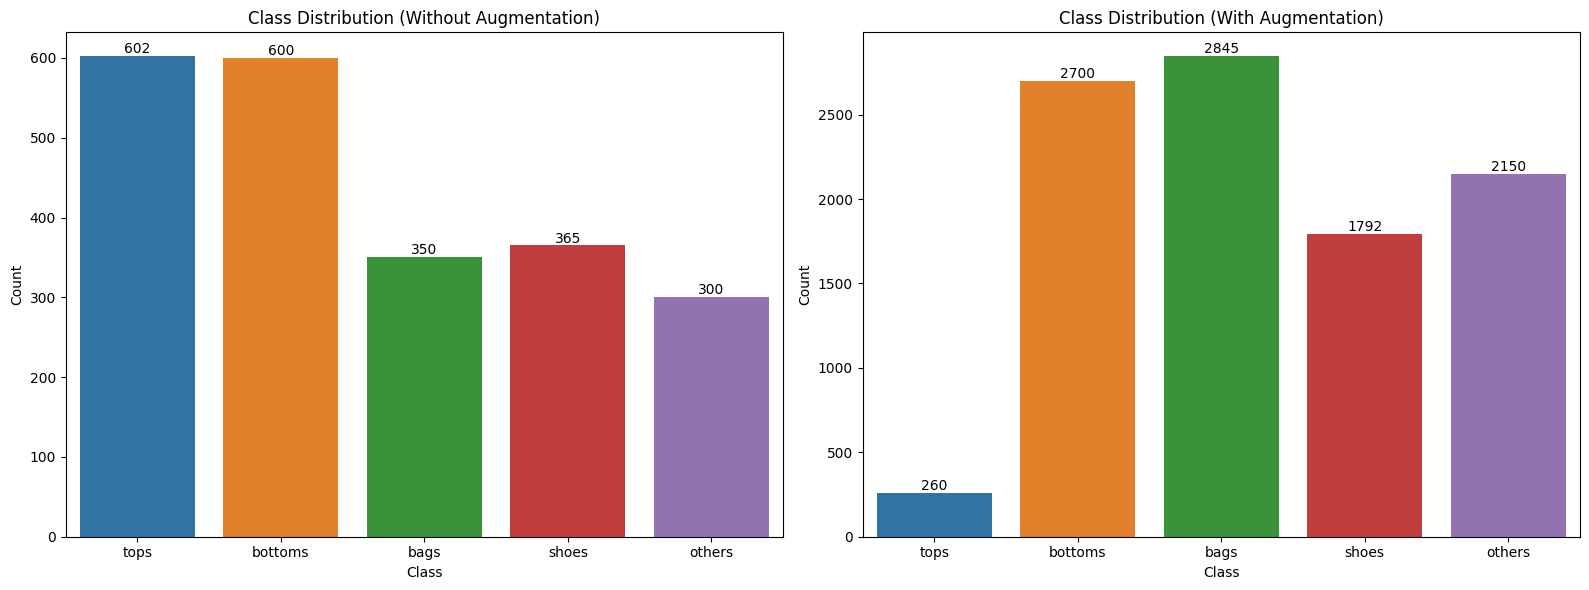

In [53]:
# Create a figure and a grid of subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the first countplot (without augmentation) on the first subplot
sns.countplot(x='category', data=initial_dims_non_augmented, ax=axes[0])
axes[0].set_title('Class Distribution (Without Augmentation)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Annotate counts on top of each bar in the first plot
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

# Plot the second countplot (with augmentation) on the second subplot
sns.countplot(x='label_name', data=train_df, ax=axes[1])
axes[1].set_title('Class Distribution (With Augmentation)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

# Annotate counts on top of each bar in the second plot
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


# Pixel Values Distribution

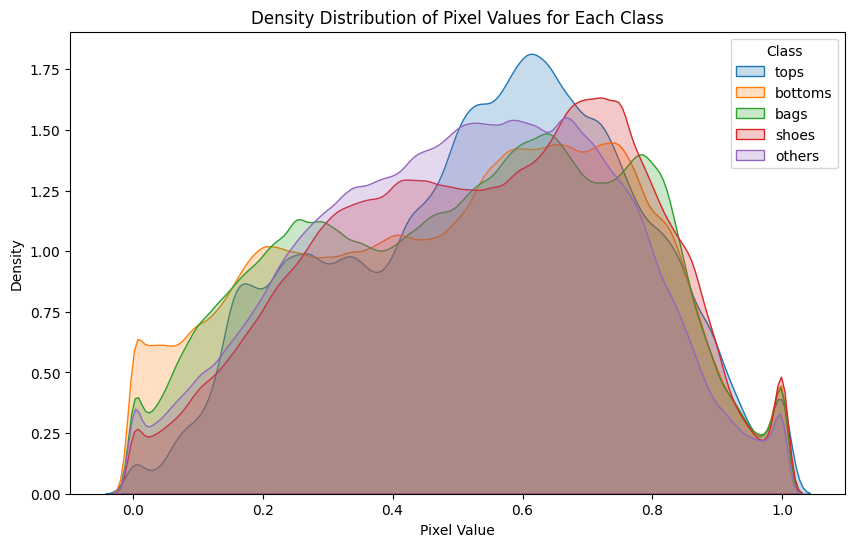

In [69]:
# Define pixel columns (adjust the range based on your actual columns)
pixel_columns = [f'pixel_{i}' for i in range(4096)]

# Plot density distributions for each class
plt.figure(figsize=(10, 6))

for class_label in range(5):  # Assuming 5 classes
    # Select data for the current class
    class_data = train_df[train_df['label'] == class_label]
    
    # Extract pixel values for the current class
    class_pixel_values = class_data[pixel_columns].values.flatten()
    
    # Plot density distribution for the current class
    sns.kdeplot(class_pixel_values, label=label_map[class_label], fill=True)

# Add plot labels and legend
plt.title('Density Distribution of Pixel Values for Each Class')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend(title='Class')

# Show plot
plt.show()

 # Average Image

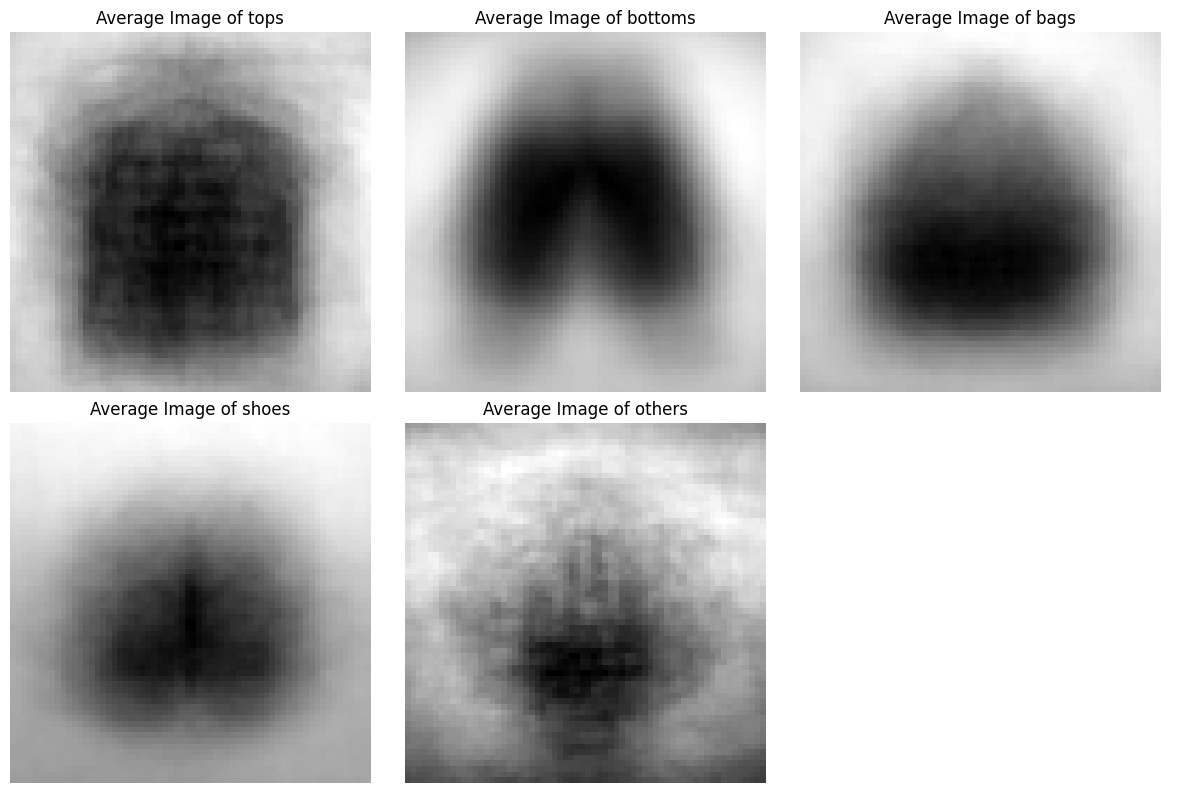

In [19]:
# Group data by the 'label' column
grouped_data = train_df.groupby('label')

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over each class label
for i, (label, group_df) in enumerate(grouped_data):
    # Select pixel data for the current class
    pixel_data = group_df[pixel_columns]
    
    # Compute mean pixel values for the current class
    mean_pixel_values = pixel_data.mean(axis=0)
    
    # Reshape mean pixel values array into image dimensions (assuming each image has dimensions of 64x64 pixels)
    mean_image = mean_pixel_values.values.reshape((64, 64))
    
    # Plot the mean image on the current subplot
    axes[i].imshow(mean_image, cmap='gray')
    axes[i].set_title(f'Average Image of {label_map[label]}')
    axes[i].axis('off')

# Hide any remaining empty subplots
for j in range(len(grouped_data), len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
